In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from __future__ import print_function
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
transform=transforms.Compose([
                       #transforms.Resize((10,10)), 
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: torch.round(x)),
                       ]
                       )

In [17]:
train_data=datasets.MNIST(root='./data', train=True, transform=transform, download=True)

test_data=datasets.MNIST(root='./data', train=False, transform = transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=512, 
    shuffle=True,
    num_workers=2, 
    pin_memory= True
    )

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=512, 
    shuffle=False, 
    num_workers=2, 
    pin_memory= True
    )

In [18]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

In [19]:
class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 100:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

In [20]:
class BinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeConv2d, self).__init__(*kargs, **kwargs)

    def forward(self, input):
        if input.size(1) != 1:
            input.data = Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)

        out = nn.functional.conv2d(input, self.weight, None, self.stride,
                                   self.padding, self.dilation, self.groups)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1, 1, 1).expand_as(out)

        return out

In [21]:
class BNN_1blk_50(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_1blk_50, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=1

        self.name='bnn_1blk_50'
        self.fc1 = BinarizeLinear(input_size,50*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(50*self.infl_ratio)
        
        self.fc5 = BinarizeLinear(50*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model= BNN_1blk_50(100,10)
model=model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)

In [22]:
def train(epoch):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)

        if epoch%25==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1
        optimizer.zero_grad()

        loss.backward()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))

        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))

In [23]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.data.max(1, keepdim=True)[1] 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 21):
    train(epoch)
    test()
    

<ipython-input-19-8799d5c4e587>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 11.382190
Train Epoch: 1 [5120/60000 (8%)]	Loss: 11.199753
Train Epoch: 1 [10240/60000 (17%)]	Loss: 11.209036
Train Epoch: 1 [15360/60000 (25%)]	Loss: 10.549888
Train Epoch: 1 [20480/60000 (34%)]	Loss: 11.007604
Train Epoch: 1 [25600/60000 (42%)]	Loss: 10.244691
Train Epoch: 1 [30720/60000 (51%)]	Loss: 10.656637
Train Epoch: 1 [35840/60000 (59%)]	Loss: 10.204641
Train Epoch: 1 [40960/60000 (68%)]	Loss: 10.319578
Train Epoch: 1 [46080/60000 (76%)]	Loss: 9.982267
Train Epoch: 1 [51200/60000 (85%)]	Loss: 10.157556
Train Epoch: 1 [56320/60000 (93%)]	Loss: 10.202606

Test set: Average loss: 0.0205, Accuracy: 1150/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 10.136294
Train Epoch: 2 [5120/60000 (8%)]	Loss: 9.924492
Train Epoch: 2 [10240/60000 (17%)]	Loss: 10.188782
Train Epoch: 2 [15360/60000 (25%)]	Loss: 9.700241
Train Epoch: 2 [20480/60000 (34%)]	Loss: 9.891101
Train Epoch: 2 [25600/60000 (42%)]	Loss: 9.588069
Train Epoch: 2 [30720/60000 (51%)]	Loss:

In [ ]:
class BNN_1blk_100(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_1blk_100, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=1

        self.name='bnn_1blk_100'
        self.fc1 = BinarizeLinear(input_size,100*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(100*self.infl_ratio)
        
        self.fc5 = BinarizeLinear(100*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        #self.drop=nn.Dropout(0.3)
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model = BNN_1blk_100(100,10)
model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)

for epoch in range(1, 21):
    train(epoch)
    test()

<ipython-input-24-79b4fb095aff>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 10.756407
Train Epoch: 1 [5120/60000 (8%)]	Loss: 10.718452
Train Epoch: 1 [10240/60000 (17%)]	Loss: 10.474772
Train Epoch: 1 [15360/60000 (25%)]	Loss: 10.633095
Train Epoch: 1 [20480/60000 (34%)]	Loss: 9.944845
Train Epoch: 1 [25600/60000 (42%)]	Loss: 10.620337
Train Epoch: 1 [30720/60000 (51%)]	Loss: 9.674362
Train Epoch: 1 [35840/60000 (59%)]	Loss: 9.433781
Train Epoch: 1 [40960/60000 (68%)]	Loss: 9.958454
Train Epoch: 1 [46080/60000 (76%)]	Loss: 9.883298
Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.145468
Train Epoch: 1 [56320/60000 (93%)]	Loss: 9.880606

Test set: Average loss: 0.0176, Accuracy: 1164/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 9.568495
Train Epoch: 2 [5120/60000 (8%)]	Loss: 9.017128
Train Epoch: 2 [10240/60000 (17%)]	Loss: 8.473452
Train Epoch: 2 [15360/60000 (25%)]	Loss: 8.460887
Train Epoch: 2 [20480/60000 (34%)]	Loss: 8.257990
Train Epoch: 2 [25600/60000 (42%)]	Loss: 7.935704
Train Epoch: 2 [30720/60000 (51%)]	Loss: 8.21706

In [ ]:
class BNN_1blk_200(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_1blk_200, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=1

        self.name='bnn_1blk_200'
        self.fc1 = BinarizeLinear(input_size,200*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(200*self.infl_ratio)
        
        self.fc5 = BinarizeLinear(200*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model = BNN_1blk_200(100,10)
model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(1, 21):
    train(epoch)
    test()
    

<ipython-input-26-ee601c6756ce>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 23.274244
Train Epoch: 1 [5120/60000 (8%)]	Loss: 23.080605
Train Epoch: 1 [10240/60000 (17%)]	Loss: 21.731188
Train Epoch: 1 [15360/60000 (25%)]	Loss: 20.710443
Train Epoch: 1 [20480/60000 (34%)]	Loss: 19.131180
Train Epoch: 1 [25600/60000 (42%)]	Loss: 19.865143
Train Epoch: 1 [30720/60000 (51%)]	Loss: 18.940939
Train Epoch: 1 [35840/60000 (59%)]	Loss: 18.909235
Train Epoch: 1 [40960/60000 (68%)]	Loss: 18.327705
Train Epoch: 1 [46080/60000 (76%)]	Loss: 17.532995
Train Epoch: 1 [51200/60000 (85%)]	Loss: 16.566486
Train Epoch: 1 [56320/60000 (93%)]	Loss: 15.817356

Test set: Average loss: 0.0325, Accuracy: 1493/10000 (15%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 16.899031
Train Epoch: 2 [5120/60000 (8%)]	Loss: 15.289644
Train Epoch: 2 [10240/60000 (17%)]	Loss: 16.029327
Train Epoch: 2 [15360/60000 (25%)]	Loss: 14.351009
Train Epoch: 2 [20480/60000 (34%)]	Loss: 13.443148
Train Epoch: 2 [25600/60000 (42%)]	Loss: 13.907084
Train Epoch: 2 [30720/60000 (51%)]	

In [ ]:
class BNN_2blk_200(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_2blk_200, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=2

        self.name='bnn_2blk_200'
        self.fc1 = BinarizeLinear(input_size,200*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(200*self.infl_ratio)

        self.fc2 = BinarizeLinear(200*self.infl_ratio,200*self.infl_ratio)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(200*self.infl_ratio)
        
        self.fc5 = BinarizeLinear(200*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model = BNN_2blk_200(100,10)
model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

for epoch in range(1, 21):
    train(epoch)
    test()
    

<ipython-input-27-046ffffacfc1>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 22.153467
Train Epoch: 1 [5120/60000 (8%)]	Loss: 21.118397
Train Epoch: 1 [10240/60000 (17%)]	Loss: 17.833776
Train Epoch: 1 [15360/60000 (25%)]	Loss: 15.187244
Train Epoch: 1 [20480/60000 (34%)]	Loss: 14.202420
Train Epoch: 1 [25600/60000 (42%)]	Loss: 12.931951
Train Epoch: 1 [30720/60000 (51%)]	Loss: 10.579212
Train Epoch: 1 [35840/60000 (59%)]	Loss: 10.786137
Train Epoch: 1 [40960/60000 (68%)]	Loss: 10.673800
Train Epoch: 1 [46080/60000 (76%)]	Loss: 9.152049
Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.666759
Train Epoch: 1 [56320/60000 (93%)]	Loss: 8.673865

Test set: Average loss: 0.0184, Accuracy: 4008/10000 (40%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 8.888513
Train Epoch: 2 [5120/60000 (8%)]	Loss: 8.556444
Train Epoch: 2 [10240/60000 (17%)]	Loss: 8.315926
Train Epoch: 2 [15360/60000 (25%)]	Loss: 7.900821
Train Epoch: 2 [20480/60000 (34%)]	Loss: 7.520447
Train Epoch: 2 [25600/60000 (42%)]	Loss: 8.607157
Train Epoch: 2 [30720/60000 (51%)]	Loss: 7.7

In [27]:
class BNN_4blk_100(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_4blk_100, self).__init__()
        self.infl_ratio=2
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=5

        self.name='bnn_4blk_100'
        self.fc1 = BinarizeLinear(input_size,784*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(784*self.infl_ratio)

        self.fc2 = BinarizeLinear(784*self.infl_ratio,784*self.infl_ratio)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(784*self.infl_ratio)

        self.fc3 = BinarizeLinear(784*self.infl_ratio,784*self.infl_ratio)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(784*self.infl_ratio)

        self.fc4 = BinarizeLinear(784*self.infl_ratio,784)
        self.htanh4 = nn.Hardtanh()
        self.bn4 = nn.BatchNorm1d(784)

        self.fc5 = nn.Linear(784,output_size)
        self.logsoftmax=nn.LogSoftmax()
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.htanh4(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model = BNN_4blk_100(784,10)
model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.8)

for epoch in range(1, 10):
    train(epoch)
    test()
    if epoch%5==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1
    

<ipython-input-27-4e9db95c5ca4>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376529
Train Epoch: 1 [5120/60000 (8%)]	Loss: 1.997602
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.584145
Train Epoch: 1 [15360/60000 (25%)]	Loss: 1.399254
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.264332
Train Epoch: 1 [25600/60000 (42%)]	Loss: 1.098429
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.061084
Train Epoch: 1 [35840/60000 (59%)]	Loss: 1.034523


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

AssertionError
: can only test a child process    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.980637
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.900107
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.865941
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.762637

Test set: Average loss: 0.0016, Accuracy: 7811/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.865754
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.765600
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.767383
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.740604
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.735134
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.703382
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.683329


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>: can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 2 [35840/60000 (59%)]	Loss: 0.750736
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.665219
Train Epoch: 2 [46080/60000 (76%)]	Loss: 0.722414
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.692144
Train Epoch: 2 [56320/60000 (93%)]	Loss: 0.608422

Test set: Average loss: 0.0013, Accuracy: 8073/10000 (81%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.664265
Train Epoch: 3 [5120/60000 (8%)]	Loss: 0.626785
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.643334
Train Epoch: 3 [15360/60000 (25%)]	Loss: 0.681312
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.595472
Train Epoch: 3 [25600/60000 (42%)]	Loss: 0.636923
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.660630


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 3 [35840/60000 (59%)]	Loss: 0.660240
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.565171
Train Epoch: 3 [46080/60000 (76%)]	Loss: 0.560687
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.644918
Train Epoch: 3 [56320/60000 (93%)]	Loss: 0.550416

Test set: Average loss: 0.0011, Accuracy: 8279/10000 (83%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.572916
Train Epoch: 4 [5120/60000 (8%)]	Loss: 0.576445
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.625927
Train Epoch: 4 [15360/60000 (25%)]	Loss: 0.591173
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.545532
Train Epoch: 4 [25600/60000 (42%)]	Loss: 0.572767


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
AssertionError: can only test a child process
if w.is_alive():
  File "/usr/lib/

Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.559285
Train Epoch: 4 [35840/60000 (59%)]	Loss: 0.574484
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.499049
Train Epoch: 4 [46080/60000 (76%)]	Loss: 0.536231
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.665544
Train Epoch: 4 [56320/60000 (93%)]	Loss: 0.634235

Test set: Average loss: 0.0011, Accuracy: 8356/10000 (84%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.613224
Train Epoch: 5 [5120/60000 (8%)]	Loss: 0.560402
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.504366
Train Epoch: 5 [15360/60000 (25%)]	Loss: 0.460353
Train Epoch: 5 [20480/60000 (34%)]	Loss: 0.559990
Train Epoch: 5 [25600/60000 (42%)]	Loss: 0.532711


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.539566


Train Epoch: 5 [35840/60000 (59%)]	Loss: 0.487383
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.535794
Train Epoch: 5 [46080/60000 (76%)]	Loss: 0.553610
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.550121
Train Epoch: 5 [56320/60000 (93%)]	Loss: 0.406247

Test set: Average loss: 0.0010, Accuracy: 8423/10000 (84%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.490868
Train Epoch: 6 [5120/60000 (8%)]	Loss: 0.523523
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.445530
Train Epoch: 6 [15360/60000 (25%)]	Loss: 0.445484
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.599536
Train Epoch: 6 [25600/60000 (42%)]	Loss: 0.543420
Train Epoch: 6 [30720/60000 (51%)]	Loss: 0.510386


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 6 [35840/60000 (59%)]	Loss: 0.484878
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.601268
Train Epoch: 6 [46080/60000 (76%)]	Loss: 0.521060
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.573457
Train Epoch: 6 [56320/60000 (93%)]	Loss: 0.587360

Test set: Average loss: 0.0010, Accuracy: 8414/10000 (84%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.465437
Train Epoch: 7 [5120/60000 (8%)]	Loss: 0.548877
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.578989
Train Epoch: 7 [15360/60000 (25%)]	Loss: 0.501326
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.508144
Train Epoch: 7 [25600/60000 (42%)]	Loss: 0.508231
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.467354


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: if w.is_alive():
can only test a child process  File "/usr/lib/p

Train Epoch: 7 [35840/60000 (59%)]	Loss: 0.499985
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.505767
Train Epoch: 7 [46080/60000 (76%)]	Loss: 0.575537
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.498939
Train Epoch: 7 [56320/60000 (93%)]	Loss: 0.631499

Test set: Average loss: 0.0010, Accuracy: 8441/10000 (84%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.533536
Train Epoch: 8 [5120/60000 (8%)]	Loss: 0.461245
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.479459
Train Epoch: 8 [15360/60000 (25%)]	Loss: 0.529279
Train Epoch: 8 [20480/60000 (34%)]	Loss: 0.477030
Train Epoch: 8 [25600/60000 (42%)]	Loss: 0.501288


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.519382
Train Epoch: 8 [35840/60000 (59%)]	Loss: 0.454983
Train Epoch: 8 [40960/60000 (68%)]	Loss: 0.468103
Train Epoch: 8 [46080/60000 (76%)]	Loss: 0.499053
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.473081
Train Epoch: 8 [56320/60000 (93%)]	Loss: 0.531106

Test set: Average loss: 0.0010, Accuracy: 8424/10000 (84%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.568402
Train Epoch: 9 [5120/60000 (8%)]	Loss: 0.573299
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.466943
Train Epoch: 9 [15360/60000 (25%)]	Loss: 0.431773
Train Epoch: 9 [20480/60000 (34%)]	Loss: 0.474870
Train Epoch: 9 [25600/60000 (42%)]	Loss: 0.534159


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa188a20dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train Epoch: 9 [30720/60000 (51%)]	Loss: 0.512820
Train Epoch: 9 [35840/60000 (59%)]	Loss: 0.500711
Train Epoch: 9 [40960/60000 (68%)]	Loss: 0.543631
Train Epoch: 9 [46080/60000 (76%)]	Loss: 0.527349
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.591583
Train Epoch: 9 [56320/60000 (93%)]	Loss: 0.479978

Test set: Average loss: 0.0010, Accuracy: 8437/10000 (84%)



In [28]:
class BNN_1blk_100(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN_1blk_100, self).__init__()
        self.infl_ratio=1
        self.input_size=input_size
        self.output_size=output_size
        self.num_internal_blocks=1

        self.name='bnn_1blk_100'
        self.fc1 = BinarizeLinear(input_size,100*self.infl_ratio)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(100*self.infl_ratio)
        
        self.fc5 = BinarizeLinear(100*self.infl_ratio,output_size)
        self.logsoftmax=nn.LogSoftmax()
        #self.drop=nn.Dropout(0.3)
        self.binarize_func=Binarize

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.binarize_func(x)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)

        x = self.fc5(x)
        return self.logsoftmax(x)

model = BNN_1blk_100(100,10)
model=model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

for epoch in range(1, 21):
    train(epoch)
    test()
    

RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(),'mnist-100-bnn_1blk_100.pt',_use_new_zipfile_serialization=False)

Now on the saved Py-Torch model for a 1blk-100 neuron inversion is performed by encoding it into a CNF Formula.
The images generated from inversion are next imported in & then evaluated on the same previously trained model for the labels.

In [ ]:
state_dict = torch.load('mnist-100-bnn_1blk_100.pt')

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
from PIL import Image
with open('100-100-10-in-asn-bin-rc-3.txt','r') as f:
  rows=f.readlines()

img=Image.new('1',(10,10),0)

for row in range(10):
  for col in range(10):
    pixel_val=int(rows[row][col])
    img.putpixel((col,row),pixel_val)

img.save('100-100-10-in-asn-3.png')


In [ ]:
input_img=Image.open('100-100-10-in-asn-3.png')
input_img.show()

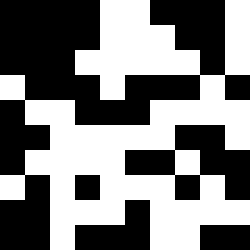

In [ ]:
resized_img=input_img.resize((250,250))
resized_img.show()

In [ ]:
test_transform=transforms.Compose([
    transforms.ToTensor()
])
input=transform(input_img)

In [ ]:
input.shape

torch.Size([1, 10, 10])

In [ ]:
input=input.unsqueeze(0)
input.shape

torch.Size([1, 1, 10, 10])

In [ ]:
model=model.to(device)
input=input.to(device)
model.eval()
output=model(input)

<ipython-input-11-82d9f8051f87>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


In [ ]:
_, predicted_label=torch.max(output,1)
print('Predicted Label:',predicted_label.item())

Predicted Label: 9


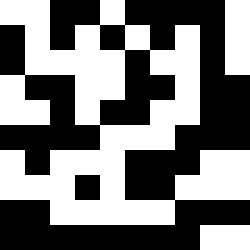

In [ ]:
from PIL import Image
with open('100-100-10-in-asn-bin-rc-1.txt','r') as f:
  rows=f.readlines()

img=Image.new('1',(10,10),0)

for row in range(10):
  for col in range(10):
    pixel_val=int(rows[row][col])
    img.putpixel((col,row),pixel_val)

img.save('100-100-10-in-asn-1.png')

input_img=Image.open('100-100-10-in-asn-1.png')
input_img.show()
resized_img=input_img.resize((250,250))
resized_img.show()

In [ ]:
test_transform=transforms.Compose([
    transforms.ToTensor()
])
input=transform(input_img)
input=input.unsqueeze(0)
model=model.to(device)
input=input.to(device)
model.eval()
output=model(input)
_, predicted_label=torch.max(output,1)
print('Predicted Label:',predicted_label.item())

Predicted Label: 9


<ipython-input-11-82d9f8051f87>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


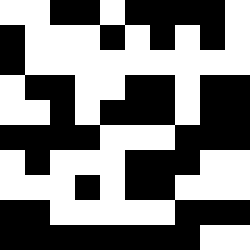

In [ ]:
from PIL import Image
with open('100-100-10-in-asn-bin-rc-2.txt','r') as f:
  rows=f.readlines()

img=Image.new('1',(10,10),0)

for row in range(10):
  for col in range(10):
    pixel_val=int(rows[row][col])
    img.putpixel((col,row),pixel_val)

img.save('100-100-10-in-asn-2.png')

input_img=Image.open('100-100-10-in-asn-2.png')
input_img.show()
resized_img=input_img.resize((250,250))
resized_img.show()

In [ ]:
test_transform=transforms.Compose([
    transforms.ToTensor()
])
input=transform(input_img)
input=input.unsqueeze(0)
model=model.to(device)
input=input.to(device)
model.eval()
output=model(input)
_, predicted_label=torch.max(output,1)
print('Predicted Label:',predicted_label.item())

Predicted Label: 9


<ipython-input-11-82d9f8051f87>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(x)


In [ ]:
class Conv_BNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(Conv_BNN, self).__init__()
        self.features = nn.Sequential(
            BinarizeConv2d(1, 10, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(10),
            nn.Hardtanh(inplace=True),

            BinarizeConv2d(10, 100, kernel_size=3,  stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(100),
            nn.Hardtanh(inplace=True),

            BinarizeConv2d(100, 100, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(100),
            nn.Hardtanh(inplace=True)

        )
        self.classifier = nn.Sequential(
            BinarizeLinear(2500, 1000),
            nn.BatchNorm1d(1000),
            nn.Hardtanh(inplace=True),

            BinarizeLinear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.Hardtanh(inplace=True),

            BinarizeLinear(1000, 10),
            nn.BatchNorm1d(10),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 2500)
        x = self.classifier(x)
        return x

model = Conv_BNN()
model=model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(1, 21):
    train(epoch)
    test()
    if epoch%10==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.734086
Train Epoch: 1 [5120/60000 (8%)]	Loss: 1.337730
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.176540
Train Epoch: 1 [15360/60000 (25%)]	Loss: 1.085139
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.043215
Train Epoch: 1 [25600/60000 (42%)]	Loss: 0.998680
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.012094
Train Epoch: 1 [35840/60000 (59%)]	Loss: 0.954217
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.890117
Train Epoch: 1 [46080/60000 (76%)]	Loss: 0.958398
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.947293
Train Epoch: 1 [56320/60000 (93%)]	Loss: 0.873135

Test set: Average loss: 0.0018, Accuracy: 8043/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.904239
Train Epoch: 2 [5120/60000 (8%)]	Loss: 0.871505
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.911709
Train Epoch: 2 [15360/60000 (25%)]	Loss: 0.889734
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.865589
Train Epoch: 2 [25600/60000 (42%)]	Loss: 0.871363
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.834055
Tra

In [ ]:
torch.save(model, 'mnist_conv_bnn.pt')
MNIST_Conv_BNN = torch.load('mnist_conv_bnn.pt')

In [ ]:
for name, param in MNIST_Conv_BNN.state_dict().items():
    print(name, param)

features.0.weight tensor([[[[ 1.,  1.,  1.],
          [ 1., -1., -1.],
          [ 1., -1., -1.]]],


        [[[ 1., -1., -1.],
          [-1., -1., -1.],
          [ 1.,  1., -1.]]],


        [[[-1., -1.,  1.],
          [ 1.,  1.,  1.],
          [ 1.,  1.,  1.]]],


        [[[-1.,  1., -1.],
          [-1., -1.,  1.],
          [-1., -1., -1.]]],


        [[[ 1., -1., -1.],
          [ 1., -1., -1.],
          [-1.,  1., -1.]]],


        [[[-1., -1.,  1.],
          [-1.,  1., -1.],
          [ 1., -1., -1.]]],


        [[[ 1.,  1., -1.],
          [-1., -1., -1.],
          [-1., -1.,  1.]]],


        [[[ 1., -1.,  1.],
          [ 1.,  1.,  1.],
          [-1., -1.,  1.]]],


        [[[-1.,  1.,  1.],
          [ 1., -1., -1.],
          [ 1.,  1., -1.]]],


        [[[ 1.,  1.,  1.],
          [-1., -1., -1.],
          [-1., -1., -1.]]]], device='cuda:0')
features.0.bias tensor([ 0.0726,  0.1147,  0.2424, -0.0222,  0.2989,  0.0501,  0.2348,  0.2349,
         0.2278,  0.

The subsequent part of the code includes the compilation of different libraries required for converting the bnn into cnf formula including;

Cryptominisat,

pblib

Cmake

NPAQ

Z3
However the same was exectued locally due to unavailabitiy of different libraries and python 2.7 in Colab which is a requirement for NPAQ.

In [ ]:
!sudo git clone https://github.com/master-keying/pblib.git

Cloning into 'pblib'...
remote: Enumerating objects: 418, done.
remote: Total 418 (delta 0), reused 0 (delta 0), pack-reused 418
Receiving objects: 100% (418/418), 840.91 KiB | 6.52 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [ ]:
%cd pblib

/content/pblib


In [ ]:
!cmake -H. -Bbuild

-- The CXX compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMake Error at CMakeLists.txt:22 (add_subdirectory):
  The source directory

    /content/pblib/cli/minisat

  does not contain a CMakeLists.txt file.


-- Configuring incomplete, errors occurred!
See also "/content/pblib/build/CMakeFiles/CMakeOutput.log".


In [ ]:
!sudo git clone https://github.com/master-keying/pblib.git

Cloning into 'pblib'...
remote: Enumerating objects: 418, done.
remote: Total 418 (delta 0), reused 0 (delta 0), pack-reused 418
Receiving objects: 100% (418/418), 840.91 KiB | 6.78 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [ ]:
!cmake -H. -Bbuild

CMake Error: The source directory "/root" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.


In [ ]:
!--help

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--pretty-print
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [ ]:
!sudo git clone https://github.com/jia-kai/eevbnn.git

Cloning into 'eevbnn'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 94 (delta 36), reused 86 (delta 28), pack-reused 0
Unpacking objects: 100% (94/94), 259.54 KiB | 2.92 MiB/s, done.


In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tqdm torch torchvision cython opencv-python 'python-sat[pblib,aiger]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.7 MB/s eta 0:00:00


In [ ]:
%cd eevbnn

/content/pblib/eevbnn


In [ ]:
!pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 13.0 MB/s eta 0:00:00
  Created wheel for parsimonious: filename=parsimonious-0

In [ ]:

%cd /content/eevbnn/eevbnn

/content/eevbnn/eevbnn


In [ ]:
!git clone https://github.com/jia-kai/minisatcs.git

Cloning into 'minisatcs'...
remote: Enumerating objects: 2270, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2270 (delta 0), reused 6 (delta 0), pack-reused 2263
Receiving objects: 100% (2270/2270), 5.65 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (1297/1297), done.


In [ ]:
%cd /content/eevbnn/eevbnn/minisatcs

/content/eevbnn/eevbnn/minisatcs


In [ ]:
!mkdir build

In [ ]:
%cd build

/content/eevbnn/eevbnn/minisatcs/build


In [ ]:
!cmake .. -DCMAKE_BUILD_TYPE=RelWithDebInfo

-- The CXX compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found ZLIB: /usr/lib/x86_64-linux-gnu/libz.so (found version "1.2.11") 
-- Registering integration tests
-- Configuring done
-- Generating done
-- Build files have been written to: /content/eevbnn/eevbnn/minisatcs/build


In [ ]:
!make -j$(nproc)

[ 11%] Building CXX object CMakeFiles/libminisat.dir/minisat/core/Solver.cc.o
[ 22%] Building CXX object CMakeFiles/libminisat.dir/minisat/utils/Options.cc.o
[ 33%] Building CXX object CMakeFiles/libminisat.dir/minisat/utils/System.cc.o
[ 44%] Building CXX object CMakeFiles/libminisat.dir/minisat/simp/SimpSolver.cc.o
[ 55%] Linking CXX static library libminisat.a
[ 55%] Built target libminisat
[ 66%] Building CXX object CMakeFiles/minisat.dir/minisat/core/Main.cc.o
[ 77%] Building CXX object CMakeFiles/minisat-simp.dir/minisat/simp/Main.cc.o
[ 88%] Linking CXX executable minisat
[100%] Linking CXX executable minisat-simp
[100%] Built target minisat
[100%] Built target minisat-simp


In [ ]:
%cd /content/eevbnn

/content/eevbnn


In [ ]:
!pip install z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 17.1 MB/s eta 0:00:00


In [ ]:
!python -m eevbnn eval_bin -e 0.08 last.pth

Streaming output truncated to the last 5000 lines.
build: time=0.076s avg_free_vars=1.06
numerical=[ 0.7 -4.7  1.5  4.6  0.   0.3  1.8 -2.4 -1.   4.2] class=3 label=9 diff=0.08/0.08
#4238: result=SAT   time=0.001s accum=0/4238=0.00%
build: time=0.079s avg_free_vars=1.07
numerical=[-0.8 -4.7  4.6  3.  -3.1 -1.3 -2.9  3.9 -2.6 -0.5] class=2 label=7 diff=0.08/0.08
#4239: result=SAT   time=0.012s accum=0/4239=0.00%
build: time=0.074s avg_free_vars=1.07
numerical=[ 0.7 -1.5 -3.2  1.5 -3.1  8.1  8.1 -4.   3.7 -0.5] class=5 label=6 diff=0.08/0.08
#4240: result=SAT   time=0.008s accum=0/4240=0.00%
build: time=0.077s avg_free_vars=1.07
numerical=[-4.  -1.5 -3.2  4.6 -3.1 -1.3 -4.5 -2.4 -2.6  4.2] class=3 label=9 diff=0.08/0.08
#4241: result=SAT   time=0.001s accum=0/4241=0.00%
build: time=0.070s avg_free_vars=1.09
numerical=[ 5.5 -3.1  1.5 -1.7  1.6 -2.9 -4.5  2.3 -1.   7.3] class=9 label=0 diff=0.08/0.08
#4242: result=SAT   time=0.047s accum=0/4242=0.00%
build: time=0.071s avg_free_vars=1.06
n

In [ ]:
%cd

/root


Criptominisat

In [ ]:
!sudo apt-get install build-essential cmake

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!sudo apt-get install zlib1g-dev libboost-program-options-dev libboost-serialization-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-program-options-dev is already the newest version (1.71.0.0ubuntu2).
libboost-program-options-dev set to manually installed.
libboost-serialization-dev is already the newest version (1.71.0.0ubuntu2).
libboost-serialization-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu1.5).
zlib1g-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!git clone https://github.com/msoos/cryptominisat.git

Cloning into 'cryptominisat'...
remote: Enumerating objects: 86727, done.
remote: Counting objects: 100% (9179/9179), done.
remote: Compressing objects: 100% (2027/2027), done.
remote: Total 86727 (delta 7281), reused 8863 (delta 7122), pack-reused 77548
Receiving objects: 100% (86727/86727), 58.47 MiB | 16.96 MiB/s, done.
Resolving deltas: 100% (67421/67421), done.


In [ ]:
%cd cryptominisat

/root/cryptominisat


In [ ]:
!mkdir build

In [ ]:
%cd build

/root/cryptominisat/build


In [ ]:
!cmake ..

-- The CXX compiler identification is GNU 9.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- LIB directory is ''
-- BIN directory is ''
-- You can choose the type of build, options are:Debug;Release;RelWithDebInfo;MinSizeRel
-- Doing a RelWithDebInfo build
-- The C compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- tbuddy not found, not compiling with tbuddy-based GJ FRAT proofs
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Failed
-- Check if compiler accepts -pthread
-- Check if compiler accepts -pthread - yes
-- Found Threads: TRUE  
-- build type is RelWithDebInfo
-- Performing Test HAVE_FLAG

In [ ]:
!make

[  1%] Building CXX object cmsat5-src/CMakeFiles/cryptominisat5.dir/cnf.cpp.o
In file included from /root/cryptominisat/src/cnf.h:35,
                 from /root/cryptominisat/src/cnf.cpp:23:
/root/cryptominisat/src/frat.h: In instantiation of ‘CMSat::Drat& CMSat::DratFile<binfrat>::operator<<(const char*) [with bool binfrat = false]’:
/root/cryptominisat/src/frat.h:417:19:   required from here
/root/cryptominisat/src/frat.h:417:42: warning: unused parameter ‘str’ [-Wunused-parameter]
  417 |     virtual Drat& operator<<(const char* str) override
      |                              ~~~~~~~~~~~~^~~
[  3%] Building CXX object cmsat5-src/CMakeFiles/cryptominisat5.dir/frat.cpp.o
[  5%] Building CXX object cmsat5-src/CMakeFiles/cryptominisat5.dir/propengine.cpp.o
[  7%] Building CXX object cmsat5-src/CMakeFiles/cryptominisat5.dir/varreplacer.cpp.o
/root/cryptominisat/src/varreplacer.cpp: In member function ‘bool CMSat::VarReplacer::handleAlreadyReplaced(CMSat::Lit, CMSat::Lit)’:
/root/cryp

In [ ]:
!sudo make install

[ 85%] Built target cryptominisat5
Copying cryptominisat_c.h to /root/cryptominisat/build/include/cryptominisat5
Copying cryptominisat.h to /root/cryptominisat/build/include/cryptominisat5
Copying solvertypesmini.h to /root/cryptominisat/build/include/cryptominisat5
Copying dimacsparser.h to /root/cryptominisat/build/include/cryptominisat5
Copying streambuffer.h to /root/cryptominisat/build/include/cryptominisat5
[ 85%] Built target CopyPublicHeaders
[ 94%] Built target cryptominisat5-bin
[100%] Built target cryptominisat5_simple-bin
Install the project...
-- Install configuration: "RelWithDebInfo"
-- Installing: /usr/local/lib/cmake/cryptominisat5/cryptominisat5ConfigVersion.cmake
-- Installing: /usr/local/lib/cmake/cryptominisat5/cryptominisat5Config.cmake
-- Installing: /usr/local/lib/cmake/cryptominisat5/cryptominisat5Targets.cmake
-- Installing: /usr/local/lib/cmake/cryptominisat5/cryptominisat5Targets-relwithdebinfo.cmake
-- Installing: /usr/local/lib/libcryptominisat5.so.5.11
--

In [ ]:
!sudo ldconfig

Python 2.7

In [ ]:
!python --version

Python 3.9.16


In [ ]:
!sudo update-alternatives --install /usr/bin/python2 python2 /usr/bin/python2.7 1

In [ ]:
!sudo update-alternatives --config python3


There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.9   2         auto mode
  1            /usr/bin/python3.8   1         manual mode
  2            /usr/bin/python3.9   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 0


NPAQ

In [ ]:
%cd

/root


In [ ]:
!git clone https://github.com/teobaluta/NPAQ.git

Cloning into 'NPAQ'...
remote: Enumerating objects: 316, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 316 (delta 22), reused 8 (delta 8), pack-reused 267
Receiving objects: 100% (316/316), 3.42 MiB | 10.07 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
%cd NPAQ

/root/NPAQ


In [ ]:
%cd mlp2cnf

/root/NPAQ/mlp2cnf


In [ ]:
!make

Checking dep pblib
mkdir: cannot create directory ‘pblib’: File exists
pblib/
pblib/PBParser.cpp
pblib/CMakeFiles/
pblib/CMakeFiles/tar.dir/
pblib/CMakeFiles/tar.dir/cmake_clean.cmake
pblib/CMakeFiles/tar.dir/build.make
pblib/CMakeFiles/tar.dir/DependInfo.cmake
pblib/CMakeFiles/tar.dir/progress.make
pblib/CMakeFiles/pbencoder.dir/
pblib/CMakeFiles/pbencoder.dir/cmake_clean.cmake
pblib/CMakeFiles/pbencoder.dir/build.make
pblib/CMakeFiles/pbencoder.dir/flags.make
pblib/CMakeFiles/pbencoder.dir/DependInfo.cmake
pblib/CMakeFiles/pbencoder.dir/link.txt
pblib/CMakeFiles/pbencoder.dir/depend.make
pblib/CMakeFiles/pbencoder.dir/progress.make
pblib/CMakeFiles/setup.dir/
pblib/CMakeFiles/setup.dir/cmake_clean.cmake
pblib/CMakeFiles/setup.dir/build.make
pblib/CMakeFiles/setup.dir/DependInfo.cmake
pblib/CMakeFiles/setup.dir/progress.make
pblib/CMakeFiles/pblib.dir/
pblib/CMakeFiles/pblib.dir/depend.internal
pblib/CMakeFiles/pblib.dir/CXX.includecache
pblib/CMakeFiles/pblib.dir/encoder/
pblib/CMake

In [ ]:
!pip3 install virtualenv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 47.7 MB/s eta 0:00:00


In [ ]:
!virtualenv npaq

created virtual environment CPython3.9.16.final.0-64 in 894ms
  creator CPython3Posix(dest=/root/NPAQ/mlp2cnf/npaq, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==23.0.1, setuptools==67.4.0, wheel==0.38.4
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
%cd NPAQ

/root/NPAQ


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached absl-py-0.2.2.tar.gz (82 kB)
  Preparing metadata (setup.py) ... done
  Using cached astor-0.6.2-py2.py3-none-any.whl (26 kB)
  Using cached backports.functools_lru_cache-1.5-py2.py3-none-any.whl (7.0 kB)
  Using cached backports.shutil_get_terminal_size-1.0.0-py2.py3-none-any.whl (6.5 kB)
  Using cached backports.weakref-1.0.post1-py2.py3-none-any.whl (5.2 kB)
  Using cached beautifultable-0.5.3-py2.py3-none-any.whl (16 kB)
  Using cached bleach-1.5.0-py2.py3-none-any.whl (17 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached decorator-4.3.0-py2.py3-none-any.whl (9.2 kB)
  Using cached enum34-1.1.6-py3-none-any.whl (12 kB)
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
ERROR: Ignored the following versions that require a different python version: 3.1.1.post1 Requires-Python >=2.6, <3; 3.2.0 Requires-Python >=2.6, <3; 3.3.0 Requires-Py

In [ ]:
%pwd

'/root/NPAQ'

In [ ]:
!./setup.sh

Cloning into 'z3'...
remote: Enumerating objects: 156127, done.
remote: Counting objects: 100% (537/537), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 156127 (delta 322), reused 502 (delta 301), pack-reused 155590
Receiving objects: 100% (156127/156127), 124.47 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (129265/129265), done.
opt = --python, arg = 
Set Assembly Version (DEFAULT): 4 12 2 0
New component: 'util'
New component: 'polynomial'
New component: 'interval'
New component: 'dd'
New component: 'simplex'
New component: 'hilbert'
New component: 'automata'
New component: 'params'
New component: 'realclosure'
New component: 'subpaving'
New component: 'ast'
New component: 'smt_params'
New component: 'parser_util'
New component: 'euf'
New component: 'grobner'
New component: 'sat'
New component: 'nlsat'
New component: 'lp'
New component: 'rewriter'
New component: 'bit_blaster'
New component: 'normal_forms'
New component: 'substitution'
New component: 'proofs

In [ ]:
!export PYTHONPATH=$HOME/usr/lib/python-2.7/site-packages:$PYTHONPATH


In [ ]:
%cd NPAQ

/root/NPAQ


In [ ]:
!python -c 'import z3;'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'z3'


In [ ]:
!python npaq --help

Traceback (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/root/NPAQ/npaq/__main__.py", line 3, in <module>
    import arg_parser
  File "/root/NPAQ/npaq/arg_parser.py", line 5, in <module>
    import models
  File "/root/NPAQ/npaq/models/__init__.py", line 2, in <module>
    from .bnn import *
  File "/root/NPAQ/npaq/models/bnn.py", line 8, in <module>
    import mc
  File "/root/NPAQ/npaq/mc.py", line 6, in <module>
    import utils
  File "/root/NPAQ/npaq/utils.py", line 6, in <module>
    import ConfigParser
ModuleNotFoundError: No module named 'ConfigParser'
